In [1]:
import numpy as np
import pandas as pd
import json
import nltk
from scipy import stats

import matplotlib.pyplot as plt

%matplotlib inline

**Important this dataset evaluates only reviewers who have purchased five or more items from Amazon's pet supplies**

In [2]:
df = pd.read_json('reviews_Pet_Supplies_5.json', lines=True)
#lines = True is for parsing more than one block of data from your json

In [3]:
meta_df = pd.read_json('meta_Pet_Supplies.json', lines=True)

In [4]:
meta_df

,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,details
0,"[Pet Supplies, Dogs, Health Supplies, Hip &amp...",,[Dr. Rexy hemp oil has powerful anti-inflammat...,,DR.REXY Hemp Oil for Dogs and Cats - 100% Orga...,[],[https://images-na.ssl-images-amazon.com/image...,,DR.REXY,[Made strictly with organic derived ingredient...,"[>#93,463 in Grocery &amp; Gourmet Food (See T...",[],Amazon Home,,,$19.90,061539972X,NaN
1,"[Pet Supplies, Dogs]",,[Know exactly what your dog is eating with 101...,,Pet Qwerks Treat Cookbook with Cutters,[],[https://images-na.ssl-images-amazon.com/image...,,Pet Qwerks,"[Recipe book, Cookie cutters, Indoor/outdoor use]","190,234 in Pet Supplies (","[B075DYQ1PH, 1604334657, 1604336919, 163026043...",Pet Supplies,,,$7.86,0615553605,NaN
2,"[Pet Supplies, Dogs, Food, Dry]",,"[, , , ]",,The Best of 101 Dog Tricks,"[0760339740, 1592533256, 1592535305, 159253730...",[https://images-na.ssl-images-amazon.com/image...,,,[],"76,847 in Movies &amp; TV (","[1592533256, 0760339740, 1592537308, 159253530...",Movies &amp; TV,,,,0760339597,NaN
3,[],,"[, The venomous but beautiful scorpionfishes a...",,Lionfishes and Other Scorpionfishes: The Compl...,"[1911142186, 1514291983]",[https://images-na.ssl-images-amazon.com/image...,,Tfh/Nylabone,[Used Book in Good Condition],"435,039 in Pet Supplies (",[],Pet Supplies,,,$24.99,0793816793,NaN
4,"[Pet Supplies, Top Selection from AmazonPets]",,[Volume 1: 96 Words &amp; Phrases! This is the...,,Pet Media Feathered Phonics The Easy Way To Te...,"[B0002FP328, B0002FP32S, B0002FP32I, B00CAMARX...",[https://images-na.ssl-images-amazon.com/image...,,Pet Media,[Award-winning audio CD teaches parrots how to...,"52,435 in Pet Supplies (","[B0002FP328, B00CAMARXG, B0002FP32S, B0013L6CA...",Pet Supplies,,,$6.97,0972585419,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205994,"[Pet Supplies, Dogs, Collars, Harnesses & Leas...",,[<br>100% brand new and high quality. <br>A be...,,Sunlilee 3Pcs Pack Adjustable Pet Dog Puppy Ca...,[],[https://images-na.ssl-images-amazon.com/image...,,Sunlilee,"[Width:1.0cm/0.4"" Neck: 23cm/20-26cm/7.87""-10""...","737,249 in Pet Supplies (",[],Pet Supplies,,,,B01HJ9ULQW,{'ASIN: ': 'B01HJ9ULQW'}
205995,"[Pet Supplies, Dogs, Carriers & Travel Product...",,"[<br><b>Color:Coffee,Rose</b> <br><b>Size:</b>...",,"Lesypet Pet Carrier for Small Dogs, Cat/Mesh B...",[],[https://images-na.ssl-images-amazon.com/image...,,LESYPET,"[Pet carrier,size:11''x9.5''x13''/28 x 24 x 33...","766,599 in Pet Supplies (",[],Pet Supplies,,,,B01HJ9OZZA,{' Product Dimensions: ': '16.1 x 11....
205996,"[Pet Supplies, Dogs, Apparel & Accessories, Li...",,[Are you still worry about the safety issue ab...,,HAOCOO Dog Life Jacket Vest Saver Safety Swims...,[],[https://images-na.ssl-images-amazon.com/image...,,HAOCOO,[MATERIALS: High grade Polyester Oxford & Nylo...,"194,289 in Pet Supplies (","[B0081XILOU, B0081XIK4Q, B01K4TUK10, B01N4CG5B...",Pet Supplies,"class=""a-bordered a-horizontal-stripes a-spa...",,$25.99,B01HJABKBQ,"{'Shipping Weight:': '1 pounds (', 'ASIN: ': '..."
205997,"[Pet Supplies, Dogs, Collars, Harnesses & Leas...",,[Are you looking for a sturdy leash for your l...,,TEEFAN Retractable Leash 10ft for Pets Puppy D...,[],[https://images-na.ssl-images-amazon.com/image...,,TEEFAN,[High quality Material - Durable ABS plastic s...,"723,939 in Pet Supplies (",[],Pet Supplies,,,,B01HJCJ8KO,"{' Item Weight: ': '5.3 ounces', 'Shi..."


In [5]:
meta_df['sub_category'] = meta_df['category'].str[1:3].str.join('_')

In [6]:
meta_df['sub_category']

0                      Dogs_Health Supplies
1                                      Dogs
2                                 Dogs_Food
3                                          
4             Top Selection from AmazonPets
                        ...                
205994    Dogs_Collars, Harnesses & Leashes
205995      Dogs_Carriers & Travel Products
205996           Dogs_Apparel & Accessories
205997    Dogs_Collars, Harnesses & Leashes
205998    Dogs_Collars, Harnesses & Leashes
Name: sub_category, Length: 205999, dtype: object

In [7]:
meta_df_dict = meta_df[['sub_category', 'asin']].drop_duplicates()

In [8]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [9]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A14CK12J7C7JRK,1223000893,Consumer in NorCal,"[0, 0]",I purchased the Trilogy with hoping my two cat...,3,Nice Distraction for my cats for about 15 minutes,1294790400,"01 12, 2011"
1,A39QHP5WLON5HV,1223000893,Melodee Placial,"[0, 0]",There are usually one or more of my cats watch...,5,Entertaining for my cats,1379116800,"09 14, 2013"
2,A2CR37UY3VR7BN,1223000893,Michelle Ashbery,"[0, 0]",I bought the triliogy and have tested out all ...,4,Entertaining,1355875200,"12 19, 2012"
3,A2A4COGL9VW2HY,1223000893,Michelle P,"[2, 2]",My female kitty could care less about these vi...,4,Happy to have them,1305158400,"05 12, 2011"
4,A2UBQA85NIGLHA,1223000893,"Tim Isenhour ""Timbo""","[6, 7]","If I had gotten just volume two, I would have ...",3,You really only need vol 2,1330905600,"03 5, 2012"


In [10]:
print(f'Percent of unique reviewers: {(df["reviewerID"].nunique()/df.shape[0])}')

Percent of unique reviewers: 0.12580146481157659


In [11]:
df['reviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')

In [12]:
stats.describe(df['reviewerID'].value_counts())

DescribeResult(nobs=19856, minmax=(5, 147), mean=7.949033037872684, variance=26.357714501854804, skewness=5.528883983176343, kurtosis=63.33368150464476)

(0, 60)

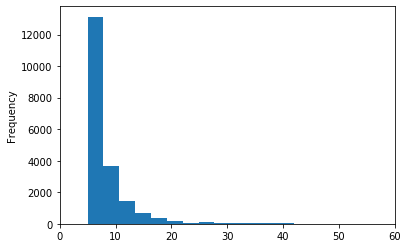

In [13]:
df['reviewerID'].value_counts().plot(kind='hist', bins = 50)
plt.xlim(left=0, right = 60)

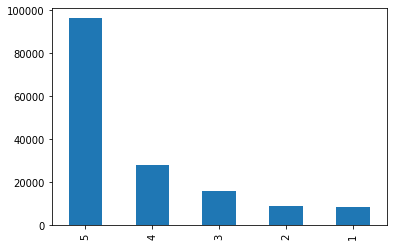

In [14]:
df['overall'].value_counts().plot(kind = 'bar')

**Map product code to subcategory**

In [15]:
np.sum(meta_df_dict['sub_category'].isnull())

0

In [16]:
df.shape

(157836, 9)

In [17]:
df = pd.merge(df, meta_df_dict,how='left', on = 'asin')

In [18]:
df['sub_category'].isnull()

0         False
1         False
2         False
3         False
4         False
          ...  
157831    False
157832    False
157833    False
157834    False
157835    False
Name: sub_category, Length: 157836, dtype: bool

There appears to be some categories where we do not have the proper labels. For those we'll use the product code as a place holder

In [19]:
df['sub_category'] = df['sub_category'].fillna(df['asin'])

In [20]:
df['sub_category']

0                                          
1                                          
2                                          
3                                          
4                                          
                        ...                
157831    Dogs_Collars, Harnesses & Leashes
157832    Dogs_Collars, Harnesses & Leashes
157833    Dogs_Collars, Harnesses & Leashes
157834    Dogs_Collars, Harnesses & Leashes
157835    Dogs_Collars, Harnesses & Leashes
Name: sub_category, Length: 157836, dtype: object

In [21]:
pd.set_option('display.max_rows', None) 
print(df['sub_category'].value_counts().sort_values(ascending=False))
pd.reset_option('display.max_rows')

Dogs_Toys                                                            13800
Dogs_Treats                                                           8756
Cats_Toys                                                             6965
Cats_Litter & Housebreaking                                           5142
Dogs_Health Supplies                                                  4245
Dogs_Grooming                                                         3946
Dogs_Food                                                             3471
Cats_Health Supplies                                                  3362
Cats_Food                                                             3192
Dogs_Collars, Harnesses & Leashes                                     3112
Cats_Beds & Furniture                                                 2848
Dogs_Feeding & Watering Supplies                                      2666
Fish & Aquatic Pets_Aquarium Pumps & Filters                          2531
Dogs_Litter & Housebreaki

**Assumption: **

Reviewers who review a product as 4 or 5 means they liked the product they purchased and those with 2 and 1 disliked the product. 


**Proposal**

Can we evaluate what product purchase tendencies by reviewers based upon products they've submitted reviews for

1) We need to create a "cart" for each reviewer so that each reviewer's aggregated purchases are placed into a list where the order is in the order of the review (assume that reviewers review products shortly after receiving them)

In [22]:
df.sort_values(by='reviewTime', inplace=True)

In [23]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,sub_category
52,AA7GFGJEAQYV5,B00005MF9T,Mrmxwll,"[257, 261]","i'm a cat lover of the first order, and presen...",5,Very Good Product,1009756800,2001-12-31,Cats_Litter & Housebreaking
109,AA7GFGJEAQYV5,B00005MF9V,Mrmxwll,"[16, 16]",the privacy tent is a very clever item.well ma...,2,Forget about it,1010188800,2002-01-05,Cats_Litter & Housebreaking
171,A3KJ80O8SLGJUL,B00005OU62,"Amazon Customer ""Book Lover""","[3, 3]",It is working GREAT!It's clean and you don't h...,5,It's Great!,1019088000,2002-04-18,Cats_Litter & Housebreaking
74,A1HGXLP6WATS4B,B00005MF9U,"F. D. Gillett ""Comparison Shopper""","[36, 37]",In a household with three adult cats I was con...,4,"It works, but............don't throw away your...",1019692800,2002-04-25,Cats_Litter &amp; Housebreaking
177,A64VV64H3KKYQ,B00005OU62,"qmsterling ""qmsterling""","[8, 8]",I have to admit the thought of dropping [$$] o...,5,"If odor is a concern, this baby is WORTH EVERY...",1027987200,2002-07-30,Cats_Litter & Housebreaking
...,...,...,...,...,...,...,...,...,...,...
154767,AJV2XY2105GOJ,B00EW2WG90,"Nancy ""Music Lover""","[0, 0]",This is a very well constructed pet carrier.I ...,5,Great!,1405987200,2014-07-22,Dogs_Carriers & Travel Products
156452,A336FE20YZZL3A,B00I18UVSO,"girlswithbooks ""girlswithbooks""","[0, 0]",Let me say up front that I have two very picky...,5,Happy Doggies!,1405987200,2014-07-22,B00I18UVSO
108726,A1AIGEDIGLGBB8,B003SE8CN2,NaN,"[0, 0]",My cats love this!,5,Five Stars,1405987200,2014-07-22,B003SE8CN2
157184,A38NEDIGZZ2ZFT,B00IK5V7ZE,Silvester Percival,"[0, 0]",I got this food for my 25-pound cocker spaniel...,4,"Good food, but contains a few more ""bad"" ingre...",1406073600,2014-07-23,Dogs_Food


In [24]:
order_cart_df = df.groupby('reviewerID')['sub_category'].apply(list).reset_index()

In [25]:
for col_name in ['overall', 'summary', 'reviewText', 'reviewTime']:
    order_cart_df[f'{col_name}'+'_list'] = df.groupby('reviewerID')[col_name].apply(list).values

In [26]:
order_cart_df['ratings_variance'] = order_cart_df['overall_list'].apply(stats.describe).str[3]

In [27]:
order_cart_df.head()

,reviewerID,sub_category,overall_list,summary_list,reviewText_list,reviewTime_list,ratings_variance
0,A04173782GDZSQ91AJ7OD,"[Dogs_Litter & Housebreaking, B007X7FJAO, B005...","[4, 5, 5, 5, 3, 4]","[Does the job, ZippyPaws Hedgehog Den, Holding...",[Definitely does it's job! It is difficult whe...,"[2014-04-24 00:00:00, 2014-04-24 00:00:00, 201...",0.666667
1,A042274212BJJVOBS4Q85,"[Dogs_Feeding & Watering Supplies, Dogs_Treats...","[5, 1, 1, 5, 2, 5, 4, 4]","[Perfect travelers with small dog. Good price,...",[It is very small. Even though it may hold 1.5...,"[2012-12-05 00:00:00, 2012-12-31 00:00:00, 201...",3.125000
2,A0436342QLT4257JODYJ,"[B0002563HM, Fish & Aquatic Pets_Aquarium Pump...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]","[Great stuff, awesome, hot, Lights, Great, Cle...",[Works great in my aquarium keeps the water sa...,"[2012-12-18 00:00:00, 2012-12-18 00:00:00, 201...",0.000000
3,A04795073FIBKY8GSLZYI,"[Dogs_Toys, Dogs_Grooming, Dogs_Grooming, Dogs...","[3, 4, 4, 3, 3, 5, 5]","[Great idea, but my dog cleaned it out too qui...",[It only took about 10 minutes for my shih tzu...,"[2013-07-18 00:00:00, 2013-07-18 00:00:00, 201...",0.809524
4,A06658082A27F4VB5UG8E,"[B001CQTOMG, B005AP3B88, Dogs_Grooming, Dogs_T...","[4, 5, 3, 3, 5, 5, 5, 5]","[Cute but thin, Very cute, Meh, Small, My dogs...",[It's a cute design and cozy material but it's...,"[2013-04-25 00:00:00, 2013-04-25 00:00:00, 201...",0.839286


In [28]:
order_cart_df.shape

(19856, 7)

**Subset**


Since majority of our ratings fall under 4 and 5's, let's subset the data to where variance is small to filter down to users who've purchased products they mostly enjoyed. We'll keep 75% of our dataset from the quantile described. We'll use apriori to evaluate some association rules to see what products appears to be purchased by the same reviewer

In [29]:
order_cart_df.ratings_variance.describe()

count    19856.000000
mean         1.204264
std          1.104270
min          0.000000
25%          0.266667
50%          0.809524
75%          1.840909
max          4.800000
Name: ratings_variance, dtype: float64

In [30]:
order_cart_df_trimmed = order_cart_df[order_cart_df['ratings_variance']<1.84]

In [31]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

In [32]:
transact_enc = TransactionEncoder()
trans_array = transact_enc.fit_transform(order_cart_df_trimmed['sub_category'], sparse=True)

In [33]:
transact_df = pd.DataFrame.sparse.from_spmatrix(trans_array, columns=transact_enc.columns_)

In [34]:
transact_rules = apriori(transact_df, min_support=0.01, use_colnames=True)

In [35]:
transact_rules[transact_rules.itemsets.apply(lambda x: len(x))>1].sort_values('support', ascending = False)

,support,itemsets
209,0.107275,"(Dogs_Treats, Dogs_Toys)"
204,0.064419,"(Dogs_Treats, Dogs_Health Supplies)"
195,0.064150,"(Dogs_Treats, Dogs_Food)"
133,0.060590,"(Cats_Litter & Housebreaking, Cats_Toys)"
177,0.058843,"(Dogs_Toys, Dogs_Collars, Harnesses & Leashes)"
...,...,...
233,0.010143,"(Dogs_Toys, Dogs_Training & Behavior Aids, Dog..."
189,0.010143,"(Dogs_Flea & Tick Control, Dogs_Treats)"
89,0.010076,"(Cats_Litter & Housebreaking, Cats_Beds &amp; ..."
162,0.010076,"(Dogs_Beds & Furniture, Dogs_Grooming)"


These are not very informative other than a sanity check. At best, we can only surmise that most reviewers own either dogs or cats but not both.

In [63]:
from nltk.corpus import stopwords
from nltk.probability import FreqDist

def title_extract(string_):
    return([title_ for title_ in string_.split() if title_.istitle() and len(title_) > 3])

In [64]:
df['company_candidates'] = df['reviewText'].apply(title_extract)

In [67]:
def stopwords_filter(list_):
    return([token for token in list_ if token.lower() not in stopwords.words('english')])

In [68]:
df['company_candidates'] = df['company_candidates'].apply(stopwords_filter)

In [73]:
from nltk.probability import FreqDist

titles_corpus = ' '.join(df['company_candidates'].str.join(' '))
title_dist = FreqDist(titles_corpus.split())
title_dist.most_common()

[('Amazon', 5426),
 ('Great', 5343),
 ('However,', 4717),
 ('Even', 2673),
 ('Good', 2511),
 ('Kong', 2435),
 ('Also,', 2411),
 ('Since', 2327),
 ('Love', 1892),
 ('Easy', 1822),
 ('German', 1616),
 ('Litter', 1606),
 ('Works', 1606),
 ('Also', 1592),
 ('Maybe', 1578),
 ('Highly', 1577),
 ('Would', 1513),
 ('Cats', 1428),
 ('Chicken', 1291),
 ('Although', 1246),
 ('Well,', 1206),
 ('Well', 1203),
 ('Blue', 1162),
 ('Bought', 1150),
 ('Amazon.', 1133),
 ('Shepherd', 1067),
 ('Natural', 1016),
 ('Dogs', 1006),
 ('But,', 995),
 ('Best', 990),
 ('Unfortunately,', 986),
 ('Purina', 945),
 ('Plus', 943),
 ('Nice', 934),
 ('First', 914),
 ('Like', 911),
 ('Wellness', 907),
 ('Sometimes', 901),
 ('Fancy', 859),
 ('However', 847),
 ('Food', 840),
 ('Definitely', 838),
 ('Thank', 838),
 ('Yes,', 805),
 ('Drinkwell', 778),
 ('Fluval', 749),
 ('Every', 747),
 ('Golden', 747),
 ('Feast', 691),
 ('Amazon,', 685),
 ('Perfect', 679),
 ('Seems', 665),
 ('Unfortunately', 659),
 ('Now,', 655),
 ('Christm